In [1]:
import importlib
importlib.reload(dark_bias)

NameError: name 'dark_bias' is not defined

In [1]:
import sys
import os
pca_path = os.path.abspath("/sdf/home/d/duncanw/repos/lsstcam-bias-stability")
eo_path = os.path.abspath('/sdf/home/d/duncanw/repos/eotest/python/lsst')
if pca_path not in sys.path:
    sys.path.append(pca_path)
if eo_path not in sys.path:
    sys.path.insert(1,eo_path)
import dark_bias 

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.time
from lsst.daf.butler import Butler
import lsst.afw

import lsst.afw.display as afwDisplay

#import lsst.eotest.image_utils as imutils
from pathlib import Path

import sklearn.linear_model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import random
from astropy.visualization import (MinMaxInterval, PercentileInterval, SqrtStretch,
                                   ImageNormalize, LogStretch)

import pickle
from astropy.stats import sigma_clip
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.formatter.useoffset'] = False
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:

from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst.cameraTransforms import ampPixelToCcdPixel

import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom

In [5]:
def mean_serial(this_bias_data):
    return np.mean(this_bias_data['serial_arr'][:,2:], axis=1)
def mean_parallel(this_bias_data):
    return np.mean(this_bias_data['parallel_arr'][2:], axis=0)
def project_principal_components(pca, arr):
    return pca.inverse_transform(pca.transform(arr))
def remove_pca_both(this_bias_data, serial_pca, parallel_pca):
    this_mean_serial = mean_serial(this_bias_data)
    this_mean_parallel = mean_parallel(this_bias_data)
    mean_bias = np.mean(np.concatenate([this_mean_parallel.flat,this_mean_serial.flat]))
    return mean_bias + (this_bias_data['im_arr']-project_principal_components(serial_pca, this_mean_serial.reshape(1, -1)).T) \
-project_principal_components(parallel_pca, this_mean_parallel.reshape(1, -1))

def get_pixel_data(exp, amp):
    
    im = exp.getMaskedImage()[amp.getRawBBox()]
    arr_imaging  = im[amp.getRawDataBBox()].getImage().getArray()
    arr_parallel = im[amp.getRawParallelOverscanBBox()].getImage().getArray()
    arr_serial   = im[amp.getRawHorizontalOverscanBBox()].getImage().getArray()

    metadata = exp.getMetadata()
    
    visit_result = [im, arr_imaging, arr_parallel, arr_serial, metadata]
    visit_result_dict = {}
    datatypes = [('masked_im', object), ('im_arr', object),('parallel_arr', object),('serial_arr', object), ('metadata', object)]
    for i, item in enumerate(visit_result):
            visit_result_dict[datatypes[i][0]] = item
        
    return visit_result_dict



In [6]:
#runs = ['12672', '12673', '12675', '12677', '12678', '12679']
raft = 'R20'
sensor = 'S21'
repo = '/sdf/group/lsst/camera/IandT/repo_gen3'

In [7]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/bot"
#repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml"
butler = Butler(repo_path)

In [8]:
registry = butler.registry

In [9]:
for c in registry.queryCollections():
    print(c)  

LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
u/jchiang/bias_12781_test/20210519T193346Z
u/jchiang/bias_12781_test/20210818T222057Z


In [10]:
collections = 'LSSTCam/raw/all'
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry


In [11]:
#for dtype in subregistry.queryDatasetTypes():
#    try:
#        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
#        print(len(datasetRefs), dtype )
#    except:
#        print("Error", dtype )

In [12]:
dtype = list(subregistry.queryDatasetTypes())[0]

In [13]:
#i = 0
#for c in subregistry.queryDatasets(datasetType='raw',collections=collections):
#    print(c.dataId)  
#    i += 1
#    if i > 30:
#        break

In [14]:
detname='R42_S11'

In [15]:
exposure_list = list(subregistry.queryDimensionRecords("exposure"))

In [16]:
runs = set()
for expid in exposure_list:
    #expid = registry.expandDataId(expid)
    runs.add(expid.science_program)

In [17]:
#runs

In [18]:
dId_large_runs = []
dId_dic = {}
minexps = 50
for run in runs:
    dIds = subbutler.registry.queryDataIds(['exposure', 'detector'] , where=f"exposure.observation_type='bias' AND exposure.science_program='{run}' AND detector.full_name='{detname}'", collections=['LSSTCam/raw/all'])#
    dIds=list(dIds)
    if len(dIds) >= minexps:
        dId_large_runs.append(dIds)
    dId_dic[run] = dIds

In [19]:
len(dId_large_runs)

40

In [20]:
dIds_12622 = list(subbutler.registry.queryDataIds(['exposure', 'detector'] , where=f"exposure.observation_type='bias' AND exposure.science_program='12622' AND detector.full_name='{detname}'", collections=['LSSTCam/raw/all']))

In [21]:
#registry.expandDataId(dIds[0]).records.keys()

In [22]:
#registry.expandDataId(dIds[0]).records['exposure']

In [23]:
#runnum = registry.expandDataId(dId).records['exposure'].science_program

In [24]:
import time

In [25]:
def get_exps(dIds, **params):
    nexps = len(dIds)
    exps = []
    try:
        for i, biasid in enumerate(dIds):
            print(f'Getting exp {i+1} of {nexps}', end='\r')
            exp = subbutler.get('raw', biasid, **params)
            exps.append(exp)
        
    except e:
        print('failed to get raw exposure')
        raise e
    print(f'Finished getting {i+1} exps                          ')
    return exps

In [26]:
#dIds = dId_large_runs[0]
#runnum = subregistry.expandDataId(dIds[0]).records['exposure'].science_program
#aspic0data, aspic1data = get_run_stats_by_aspic(dId_large_runs[0])
#
#
#aspic_arr_0 = np.array(aspic0data)
#aspic_arr_1 = np.array(aspic1data)

In [27]:
aspic0data_list = []
aspic1data_list = []

In [28]:
aspic0data_dic = {}
aspic1data_dic = {}

In [29]:
def get_aspic_bias_from_cache(dIds, detname, runnum):
    cache_file_prefix = f'aspic_stats/{detname}/{runnum}-{detname}'
    
    try:
        with open(cache_file_prefix + '-aspic0.pickle', 'rb') as f:
            aspic0data = pickle.load(f)
        with open(cache_file_prefix + '-aspic1.pickle', 'rb') as f:
            aspic1data = pickle.load(f)
        aspic0data_dic[runnum] = np.asarray(aspic0data)
        aspic1data_dic[runnum] = np.asarray(aspic1data)
    except EOFError as e:
        print(e)
        raise
    except FileNotFoundError as e:
        print("No cache found")
        raise

In [30]:
def get_run_stats_by_aspic(dIds, cache_file=None):
    aspic0data = []
    aspic1data = []
    try:
        for biasid in dIds:
            exp = subbutler.get('raw', biasid)
            det = exp.getDetector()
            aspic0_im_data = []
            aspic1_im_data = []
            for amp in det:
                #print(amp.getName())
                
                #exp.getImage().getMaskedImage()[amp.raw]
                visit_result_dict = get_pixel_data(exp, amp)
                result_list = [np.median(visit_result_dict['im_arr']), np.median(visit_result_dict['serial_arr']), np.median(visit_result_dict['parallel_arr'])]
                del visit_result_dict
                
                segname = amp.getName()
                if segname[1] == '0':
                    aspic0_im_data.append(result_list)
                elif segname[1] == '1':
                    aspic1_im_data.append(result_list)
            aspic0data.append(aspic0_im_data)
            aspic1data.append(aspic1_im_data)
            
        if cache_file is not None:
            with open(cache_file + '-aspic0.pickle', 'wb') as f:
                pickle.dump(aspic0data, f)
            with open(cache_file + '-aspic1.pickle', 'wb') as f:
                pickle.dump(aspic1data, f)
    except:
        print('failed to get raw exposure')
    
        
    return aspic0data, aspic1data

In [31]:
for i, dIds in enumerate(dId_large_runs):
    
    runnum = registry.expandDataId(dIds[0]).records['exposure'].science_program
    print(f'Getting run {runnum}')
    try:
        get_aspic_bias_from_cache(dIds, detname, runnum)
    except:
        pass
    

Getting run 12672
Getting run 12684
Getting run 12761
No cache found
Getting run 6549D
No cache found
Getting run 6813D
No cache found
Getting run 12639
Getting run 12549
Getting run 12741
Getting run 12638
Getting run unknown
No cache found
Getting run 6824D
No cache found
Getting run 6514D
No cache found
Getting run 12636
Getting run 6795D
No cache found
Getting run 6481D
No cache found
Getting run 6486D
No cache found
Getting run 6547D
No cache found
Getting run 6508D
No cache found
Getting run 6818D
No cache found
Getting run 6761D
No cache found
Getting run 6790D
No cache found
Getting run 12673
Getting run 12781
No cache found
Getting run 6755D
No cache found
Getting run 6492D
No cache found
Getting run 12619
Ran out of input
Getting run 12606
Getting run 12693
Getting run 6517D
No cache found
Getting run 12692
Getting run 6779D
No cache found
Getting run 12635
Getting run 12597
No cache found
Getting run 12629
Getting run 6488D
No cache found
Getting run 12729
Getting run 12632


In [33]:
try: 
    get_aspic_bias_from_cache(dIds_12622, detname, '12622')
except:
    aspic0data, aspic1data = get_run_stats_by_aspic(dIds_12622, f'aspic_stats/{detname}/12622-{detname}')
    aspic0data_dic['12622'] = np.asarray(aspic0data)
    aspic1data_dic['12622'] = np.asarray(aspic1data)

In [23]:

for i, dIds in enumerate(dId_large_runs):
    runnum = registry.expandDataId(dIds[0]).records['exposure'].science_program
    if runnnum in aspic0data_dic:
        aspic0data = aspic0data_dic[runnum]
        aspic1data = aspic1data_dic[runnum]
    else:
        try:
            get_aspic_bias_from_cache(dIds, detname, runnum)
        except:
            aspic0data, aspic1data = get_run_stats_by_aspic(dIds, f'aspic_stats/{detname}/{runnum}-{detname}')
            aspic0data_dic[runnum] = aspic0data
            aspic1data_dic[runnum] = aspic1data
        
    if (len(aspic0data)==0) or (len(aspic1data)==0):
        print(f'Skipping run {runnum}')
        continue
        
    aspic_arr_0 = np.asarray(aspic0data)
    aspic_arr_1 = np.asarray(aspic1data)
    
    
    
    fig = plt.figure()
    plt.scatter(np.sum(aspic_arr_0[:,:,1], axis=-1), np.sum(aspic_arr_1[:,:,1], axis=-1))
    plt.title(f'Bias states in {detname}, run {runnum}')
    plt.xlabel('ASPIC 0 bias sum (ADU)')
    plt.ylabel('ASPIC 1 bias sum (ADU)')
    fig.set_facecolor('white')
    plt.gca().ticklabel_format(useOffset=False)
    plt.show()

NameError: name 'runnnum' is not defined

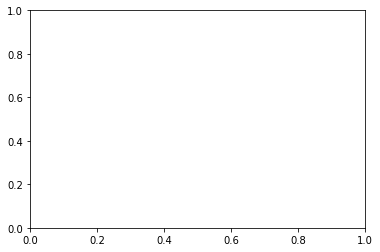

In [34]:
plt.gca().ticklabel_format(useOffset=False)

Skipping run 6549D


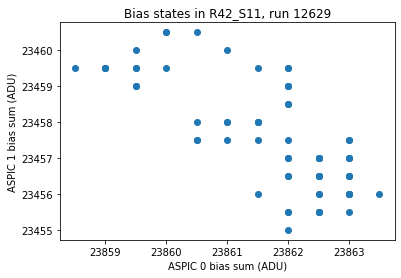

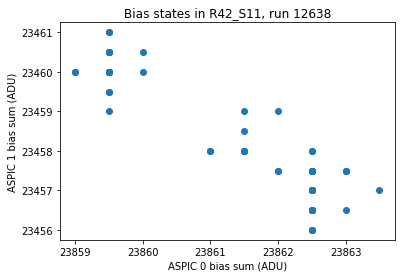

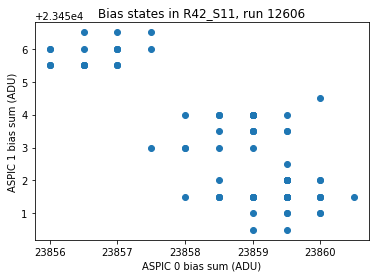

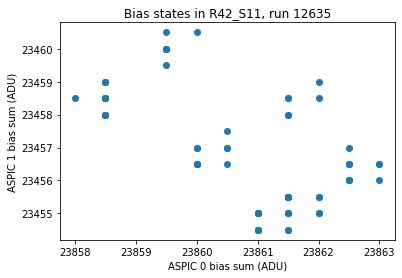

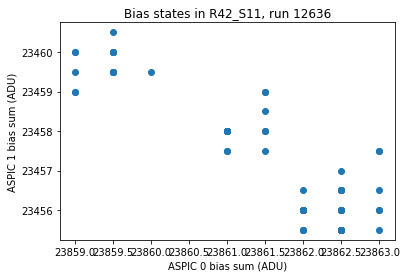

Skipping run 6755D


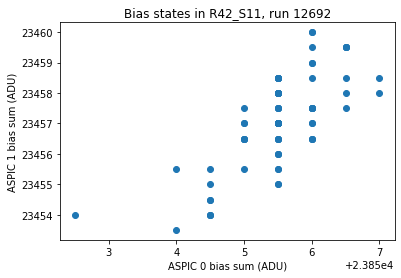

Skipping run 6818D
Skipping run 6790D
Skipping run 6486D
Skipping run 12597


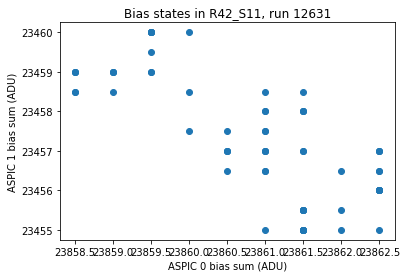

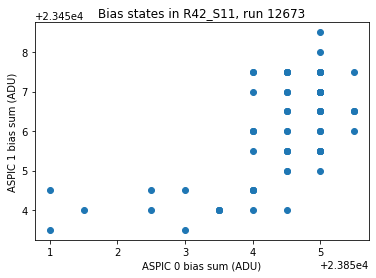

Skipping run 12781
Skipping run 6481D


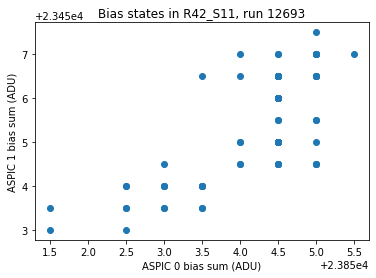

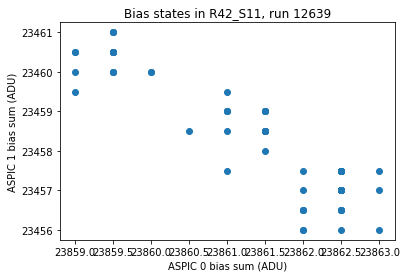

Skipping run 6761D


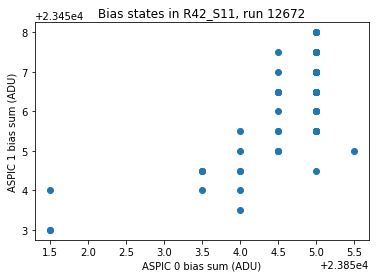

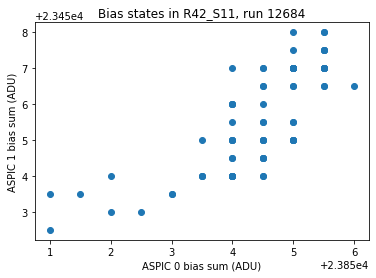

Skipping run 6795D
Skipping run 12761
Skipping run 6508D
Skipping run 6517D
Skipping run 6547D
Skipping run 6824D
Skipping run unknown
Skipping run 6605D


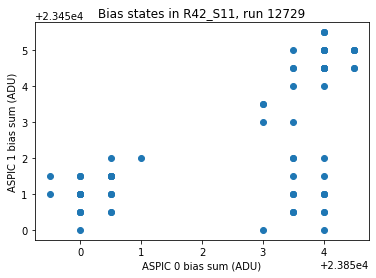

Skipping run 6492D


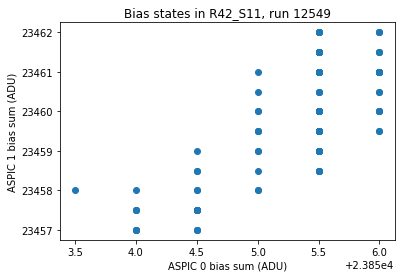

Skipping run 6779D


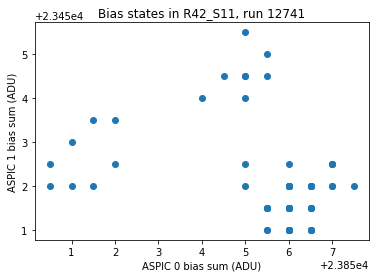

Skipping run 6488D


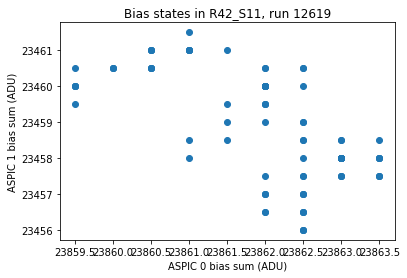

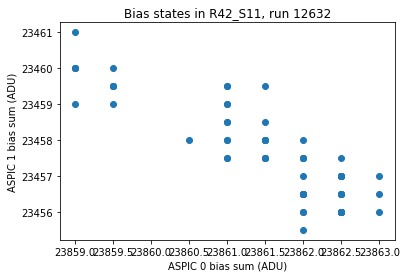

Skipping run 6813D
Skipping run 6514D
Skipping run 6545D


In [26]:
for i, dIds in enumerate(dId_large_runs):
    runnum = registry.expandDataId(dIds[0]).records['exposure'].science_program
    if (len(aspic1data_list) > i) and (len(aspic0data_list) > i):
        aspic0data = aspic0data_list[i]
        aspic1data = aspic1data_list[i]
    else:
        print('not here')
        #aspic0data, aspic1data = get_run_stats_by_aspic(dIds)
        #aspic0data_list.append(aspic0data)
        #aspic1data_list.append(aspic1data)
        
    if (len(aspic0data)==0) or (len(aspic1data)==0):
        print(f'Skipping run {runnum}')
        continue
        
    aspic_arr_0 = np.asarray(aspic0data)
    aspic_arr_1 = np.asarray(aspic1data)
    
    
    
    fig = plt.figure()
    plt.scatter(np.median(aspic_arr_0[:,:,1], axis=-1), np.median(aspic_arr_1[:,:,1], axis=-1))
    plt.title(f'Bias states in {detname}, run {runnum}')
    plt.xlabel('ASPIC 0 bias sum (ADU)')
    plt.ylabel('ASPIC 1 bias sum (ADU)')
    fig.set_facecolor('white')
    plt.show()

In [31]:
aspic1data_dic.keys()

dict_keys(['12629', '12636', '12631', '12692', '12741', '12639', '12729', '12606', '12638', '12693', '12632', '12673', '12635', '12672', '12549', '12684', '12622'])

In [48]:
runnum = '12729'

In [72]:
aspic_arr_0 = np.asarray(aspic0data_dic[runnum])
aspic_arr_1 = np.asarray(aspic1data_dic[runnum])

In [23]:
X,Y=np.sum(aspic_arr_0[:,:,1], axis=-1), np.sum(aspic_arr_1[:,:,1], axis=-1)

In [24]:
colormap = {0:'r', 1:'g', 2:'b'}

In [26]:
clusters = GaussianMixture(n_components=3, n_init=100)

In [27]:
#X = np.c_[aspic_arr_0[:,:,1],aspic_arr_1[:,:,1]]

In [28]:
data = np.c_[X,Y]

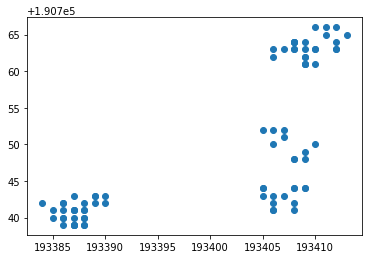

In [29]:
plt.scatter(data[:,0],data[:,1])

In [30]:
clusters = clusters.fit(data)

In [31]:
c_labels = clusters.predict(data)
c_colors = [colormap[label] for label in c_labels]

In [32]:
set(c_labels)

{0, 1, 2}

In [33]:
original_std = np.std(data,axis=0)
data_clustered = [data[c_labels == label] for label in set(c_labels)]
clustered_std = [np.std(np.asarray(this_cluster), axis=0) for this_cluster in data_clustered]

In [34]:
print(original_std)
print(clustered_std)

[10.354369  10.0501375]
[array([1.4000036, 1.3515459], dtype=float32), array([1.8083845, 1.4609692], dtype=float32), array([1.4807796, 3.782272 ], dtype=float32)]


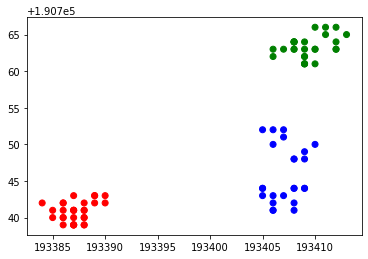

In [35]:
plt.scatter(X,Y, c=c_colors)

In [25]:
len(aspic1data_dic.keys())

16

In [34]:
minbias0, maxbias0 = np.inf, -np.inf
minbias1, maxbias1 = np.inf, -np.inf

make_plots = False

colormap = {0:'r', 1:'g', 2:'b'}

cluster_labels = {}
if make_plots:
    fig, axes = plt.subplots(4,4, figsize=(23,20))


axes_iter = 0
for runnum in sorted(aspic1data_dic.keys()):
    aspic_arr_0 = np.asarray(aspic0data_dic[runnum])
    aspic_arr_1 = np.asarray(aspic1data_dic[runnum])
    
    X,Y=np.mean(aspic_arr_0[:,:,1], axis=-1), np.mean(aspic_arr_1[:,:,1], axis=-1)
    data = np.c_[X,Y]
    
    minbias0, maxbias0 = min(minbias0, np.min(X)), max(maxbias0, np.max(X))
    minbias1, maxbias1 = min(minbias1, np.min(Y)), max(maxbias1, np.max(Y))
    
    clusters = GaussianMixture(n_components=3, n_init=100)
    clusters = clusters.fit(data)
    c_labels = clusters.predict(data)
    label_sorter = {j:i for i,j in enumerate(np.argsort(clusters.means_[:,1], axis=0)[::-1])}
    sorted_c_labels = [label_sorter[label] for label in c_labels]
    
    cluster_labels[runnum] = sorted_c_labels
    
    #colormap = {j : ['r','g','b'][i] for i,j in enumerate()}
    c_colors = [colormap[label] for label in sorted_c_labels]
    
    original_std = np.std(data,axis=0)
    data_clustered = [data[c_labels == label] for label in set(c_labels)]
    clustered_std = [np.std(np.asarray(this_cluster), axis=0) for this_cluster in data_clustered]
    
    if make_plots:
        ax = axes[axes_iter//4, axes_iter%4]

        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        ax.scatter(X,Y, c=c_colors)
        #ax.ticklabel_format(useOffset=True, axis='both')
        ax.set_xlabel('Mean of ASPIC 0 amps (ADU)')
        ax.set_ylabel('Mean of ASPIC 1 amps (ADU)')
        ax.set_title(runnum)
        ax.text(.1,.1, metas[runnum]['SEQFILE'], transform=ax.transAxes)
    axes_iter += 1
   
if make_plots:
    plt.suptitle(f'Clustering of bias exposures by mean per ASPIC of {detname} in several runs\n')
    plt.tight_layout()

    for ax in axes.flat:
        ax.ticklabel_format(useOffset=True, axis='both')
        ax.set_xlim(minbias0-.5, maxbias0+.5)
        ax.set_ylim(minbias1-.5, maxbias1+.5)
        ax.xaxis.get_major_formatter().set_useOffset(True)
        #y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
        #plt.setp(ax.get_xticklabels(), useOffset=True)
        #ax.get_yaxis().get_major_formatter().set_useOffset(True)


    plt.savefig(f'plots/clusters-{detname}.png')
    plt.show()

In [35]:
runnum='12622'

aspic_arr_0 = np.asarray(aspic0data_dic[runnum])
aspic_arr_1 = np.asarray(aspic1data_dic[runnum])

X,Y=np.mean(aspic_arr_0[:,:,1], axis=-1), np.mean(aspic_arr_1[:,:,1], axis=-1)
data = np.c_[X,Y]
clusters = GaussianMixture(n_components=3, n_init=100)
clusters = clusters.fit(data)
c_labels = clusters.predict(data)
label_sorter = {j:i for i,j in enumerate(np.argsort(clusters.means_[:,1], axis=0)[::-1])}
sorted_c_labels = [label_sorter[label] for label in c_labels]

cluster_labels[runnum] = sorted_c_labels

#colormap = {j : ['r','g','b'][i] for i,j in enumerate()}
c_colors = [colormap[label] for label in sorted_c_labels]

original_std = np.std(data,axis=0)
data_clustered = [data[c_labels == label] for label in set(c_labels)]
clustered_std = [np.std(np.asarray(this_cluster), axis=0) for this_cluster in data_clustered]

if make_plots:

    plt.scatter(X,Y, c=c_colors)
    plt.xlim(minbias0, maxbias0)
    plt.ylim(minbias1, maxbias1)


    plt.text(.1,.1, metas[runnum]['SEQFILE'], transform=plt.gca().transAxes)
    plt.title(f'Clustering of bias exposures by mean per ASPIC of {detname} in 12622\n')
    plt.savefig(f'plots/clusters-{detname}-12622.png')

In [26]:
sorted(aspic1data_dic.keys())

['12549',
 '12606',
 '12622',
 '12629',
 '12631',
 '12632',
 '12635',
 '12636',
 '12638',
 '12639',
 '12672',
 '12673',
 '12684',
 '12692',
 '12693',
 '12729',
 '12741']

In [59]:
print(list(registry.expandDataId(dId).records))
print(registry.expandDataId(dId).records['exposure'])

[DatabaseDimension(band), GovernorDimension(instrument), DatabaseDimension(detector), DatabaseDimension(physical_filter), DatabaseDimension(exposure)]
exposure:
  instrument: 'LSSTCam'
  id: 3020090600358
  physical_filter: 'SDSSi'
  obs_id: 'MC_C_20200906_000358'
  exposure_time: 0.0
  dark_time: 0.0208895
  observation_type: 'bias'
  observation_reason: 'flat'
  day_obs: 20200906
  seq_num: 358
  group_name: '3020090600358'
  group_id: 3020090600358
  target_name: 'UNKNOWN'
  science_program: '12549'
  tracking_ra: None
  tracking_dec: None
  sky_angle: None
  zenith_angle: None
  timespan: Timespan(begin=astropy.time.Time('2020-09-06 15:51:51.593020', scale='tai', format='iso'), end=astropy.time.Time('2020-09-06 15:51:51.593020', scale='tai', format='iso'))


In [36]:
metas = {}
for run in sorted(aspic1data_dic.keys()):
    dIds = subbutler.registry.queryDataIds(['exposure', 'detector'] , where=f"exposure.observation_type='bias' AND exposure.science_program='{run}' AND detector.full_name='{detname}'", collections=['LSSTCam/raw/all'])#
    dIds=list(dIds)
    dId= dIds[0]
    exp = subbutler.get('raw', dId)
    meta = exp.getMetadata()
    metas[run] = meta

In [31]:
run = runnum
dIds = subbutler.registry.queryDataIds(['exposure', 'detector'] , where=f"exposure.observation_type='bias' AND exposure.science_program='{run}' AND detector.full_name='{detname}'", collections=['LSSTCam/raw/all'])#
dIds=list(dIds)
dId= dIds[0]
exp = subbutler.get('raw', dId)
meta = exp.getMetadata()
metas[run] = meta

In [66]:
for run in sorted(aspic1data_dic.keys()):
    print(metas[run]['SEQFILE'])

FP_ITL_2s_ir2_v20.seq
FP_ITL_2s_ir2_v22.seq
FP_ITL_2s_ir2_v22_FC_05_SF.seq
FP_ITL_2s_ir2_v22_FC_10_SF.seq
FP_ITL_2s_ir2_v22_FC_05_IN_0000.seq
FP_ITL_2s_ir2_v22_FC_05_IN_0100.seq
FP_ITL_2s_ir2_v22_FC_05_IN_0600.seq
FP_ITL_2s_ir2_v22_FC_05_IN_1500.seq
FP_ITL_2s_ir2_v22_FC_05_IN_3000.seq
FP_ITL_2s_ir2_v23.seq
FP_ITL_2s_ir2_v23.seq
FP_ITL_2s_ir2_v23_ReverseInvert.seq
FP_ITL_2s_ir2_v23.seq
FP_ITL_2s_ir2_v23.seq
FP_ITL_2s_ir2_v24.seq
FP_ITL_2s_ir2_v23_FF02.seq


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

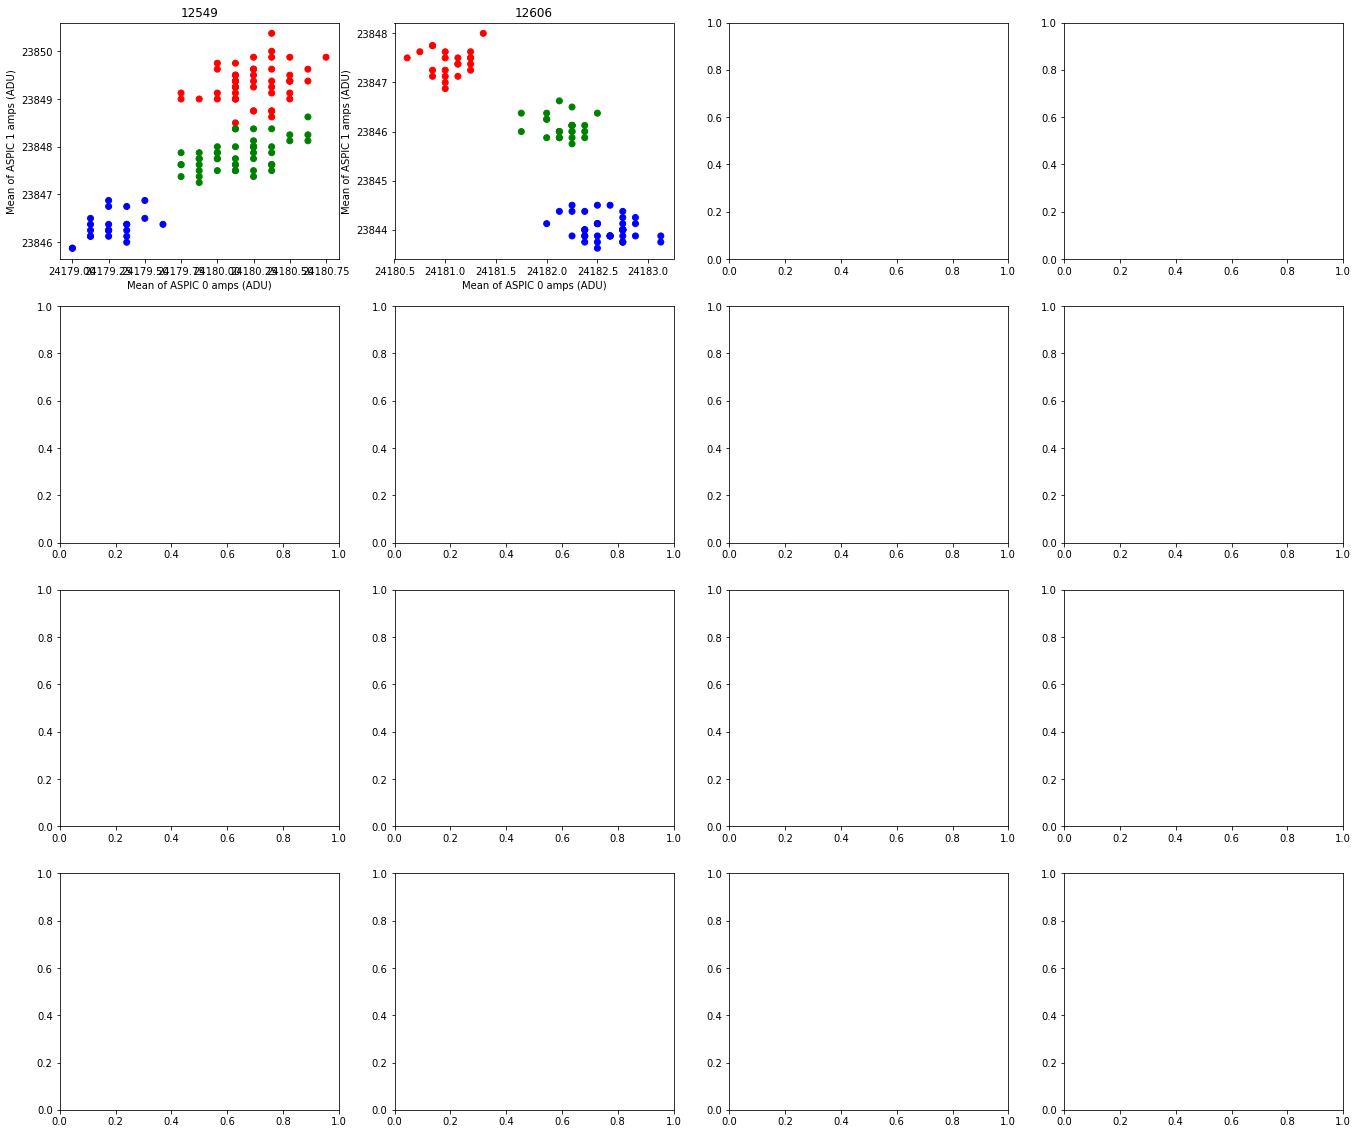

In [35]:
minbias0, maxbias0 = np.inf, -np.inf
minbias1, maxbias1 = np.inf, -np.inf

colormap = {0:'r', 1:'g', 2:'b'}

cluster_labels = {}
fig, axes = plt.subplots(4,4, figsize=(23,20))
axes_iter = 0
for runnum in sorted(list(aspic1data_dic.keys()))[:16]:
    aspic_arr_0 = np.asarray(aspic0data_dic[runnum])
    aspic_arr_1 = np.asarray(aspic1data_dic[runnum])
    
    X,Y=np.mean(aspic_arr_0[:,:,0], axis=-1), np.mean(aspic_arr_1[:,:,0], axis=-1)
    data = np.c_[X,Y]
    
    minbias0, maxbias0 = min(minbias0, np.min(X)), max(maxbias0, np.max(X))
    minbias1, maxbias1 = min(minbias1, np.min(Y)), max(maxbias1, np.max(Y))
    
    clusters = GaussianMixture(n_components=3, n_init=100)
    clusters = clusters.fit(data)
    c_labels = clusters.predict(data)
    label_sorter = {j:i for i,j in enumerate(np.argsort(clusters.means_[:,1], axis=0)[::-1])}
    sorted_c_labels = [label_sorter[label] for label in c_labels]
    
    cluster_labels[runnum] = sorted_c_labels
    
    #colormap = {j : ['r','g','b'][i] for i,j in enumerate()}
    c_colors = [colormap[label] for label in sorted_c_labels]
    
    original_std = np.std(data,axis=0)
    data_clustered = [data[c_labels == label] for label in set(c_labels)]
    clustered_std = [np.std(np.asarray(this_cluster), axis=0) for this_cluster in data_clustered]
    axes[axes_iter//4, axes_iter%4].scatter(X,Y, c=c_colors)
    #axes[axes_iter//4, axes_iter%4].ticklabel_format(useOffset=True, axis='both')
    axes[axes_iter//4, axes_iter%4].set_xlabel('Mean of ASPIC 0 amps (ADU)')
    axes[axes_iter//4, axes_iter%4].set_ylabel('Mean of ASPIC 1 amps (ADU)')
    axes[axes_iter//4, axes_iter%4].set_title(runnum)
    axes_iter += 1
   
plt.suptitle(f'Clustering of bias exposures by mean per ASPIC in several runs\n')
plt.tight_layout()

for ax in axes.flat:
    ax.ticklabel_format(useOffset=True, axis='both')
    ax.set_xlim(minbias0-.5, maxbias0+.5)
    ax.set_ylim(minbias1-.5, maxbias1+.5)
    #ax.get_xaxis().get_major_formatter().set_useOffset(True)
    #ax.get_yaxis().get_major_formatter().set_useOffset(True)

plt.savefig(f'plots/clusters-imaging-{detname}.png')
plt.show()

In [53]:
cmap = {i : ['r','g','b'][j] for i,j in enumerate(np.argsort(clusters.means_[:,0], axis=0)[::-1])}

In [54]:
clusters.means_

array([[24177.35131344, 23846.42073113],
       [24177.26238083, 23846.18032607],
       [24175.        , 23844.96875   ]])

In [79]:
testmap[0,1,2]

TypeError: unhashable type: 'list'

In [40]:
dir(clusters)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_initial_parameters',
 '_check_n_features',
 '_check_parameters',
 '_compute_lower_bound',
 '_e_step',
 '_estimate_log_prob',
 '_estimate_log_prob_resp',
 '_estimate_log_weights',
 '_estimate_weighted_log_prob',
 '_estimator_type',
 '_get_param_names',
 '_get_parameters',
 '_get_tags',
 '_initialize',
 '_initialize_parameters',
 '_m_step',
 '_more_tags',
 '_n_parameters',
 '_print_verbose_msg_init_beg',
 '_print_verbose_msg_init_end',
 '_print_verbose_msg_iter_end',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_parameters',


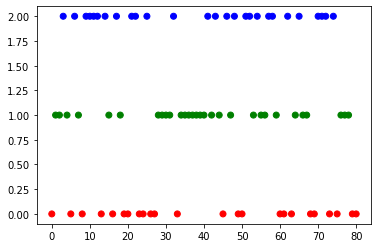

In [46]:
plt.scatter(np.arange(len(c_labels)), c_labels, linestyle='None', marker='o', color=c_colors)

In [46]:
axes_iter

16

In [237]:
dir(dark_bias)

['Butler',
 'ImageNormalize',
 'LogStretch',
 'MinMaxInterval',
 'PCA',
 'PCA_Corrector',
 'Path',
 'PercentileInterval',
 'SqrtStretch',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__main__',
 '__name__',
 '__package__',
 '__spec__',
 'astropy',
 'do_PCA_correction',
 'do_dark_clipping',
 'get_pixel_data',
 'get_selected_bias_and_dark_visits',
 'lsst',
 'make_superbias_and_dark_from_corrected_clipped',
 'make_superbias_and_dark_regression',
 'mean_parallel',
 'mean_serial',
 'np',
 'os',
 'pd',
 'pickle',
 'plot_superbias',
 'plt',
 'project_principal_components',
 'random',
 'remove_pca_both',
 'run_dark_regression_analysis_on_a_sensor',
 'run_dark_regression_analysis_on_all_sensors',
 'sigma_clip',
 'sklearn',
 'sys']

In [62]:
for dIds in dId_large_runs:
    if registry.expandDataId(dIds[0]).records['exposure'].science_program == runnum:
        
        print(registry.expandDataId(dIds[0]).records['exposure'].science_program)
        break

12741


In [35]:
dIds

[{instrument: 'LSSTCam', detector: 175, exposure: 3020111400187, ...},
 {instrument: 'LSSTCam', detector: 175, exposure: 3020111400197, ...},
 {instrument: 'LSSTCam', detector: 175, exposure: 3020111400016, ...}]

In [34]:
dId_large_runs

[[{instrument: 'LSSTCam', detector: 175, exposure: 3019100800292, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800308, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800230, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800204, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800187, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800186, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800260, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800224, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800206, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800266, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800217, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800307, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800196, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3019100800188

In [66]:
cluster_labels.keys()

dict_keys(['12622'])

In [155]:
c_labels = cluster_labels[runnum]
dIds_clustered = [[dIds[index] for index in np.where(np.asarray(c_labels) == label)[0]] for label in set(c_labels)]

In [87]:
dIds_clustered

[[{instrument: 'LSSTCam', detector: 175, exposure: 3020111400191, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400185, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400017, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400192, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400145, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400012, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400124, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400020, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400175, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400142, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400103, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400154, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400181, ...},
  {instrument: 'LSSTCam', detector: 175, exposure: 3020111400025

In [117]:
det = exp.getDetector()

In [81]:
lsst.afw.cameraGeom.detector.detector.Detector()

In [151]:
exps[0][det[3].getRawBBox()]

In [148]:
def plot_im_and_hist(data, median=False, save_file=None, show=True, im_options={}, hist_options={}, **options):
    fig,axes = plt.subplots(1,2,figsize=(15,20))
    clim=(np.min(data), np.max(data))
    implot = axes[0].imshow(data, clim=clim, **im_options)
    plt.colorbar(implot,ax=axes[0])
    axes[1].hist(data.flat, orientation='horizontal', bins=np.linspace(*clim,100), **hist_options)
    axes[1].set_ylim(clim)
    if median:
        median_val = np.median(data.flat)
        std_val = np.std(data.flat)
        axes[1].axhline(np.median(data.flat), color='black',linestyle='dashed')
        axes[1].text(0,median_val+3*std_val, f'   Median value: {median_val:.2f} ADU\n   Stdev value:  {std_val:.2f} ADU', fontsize=16)
    if 'title' in options:
        plt.title(options['title'])
    if save_file is not None:
        plt.savefig(save_file)
    if not show:
        return fig,axes 
    plt.show()
    plt.close()

In [158]:
runnum='12741'
runs=[runnum]

In [154]:
runs = ['12631', '12632', '12635', '12635']

In [159]:
mean_ims_dic = {}
std_ims_dic = {}

In [167]:
simga_clip_biases = True

make_plots = False
exp = subbutler.get('raw',dIds_clustered[0][0])
det = exp.getDetector()
amp = det[0]
for run in runs:
    mean_ims = []
    std_ims = []
    c_labels = cluster_labels[run]
    dIds = dId_dic[run]
    dIds_clustered = [[dIds[index] for index in np.where(np.asarray(c_labels) == label)[0]] for label in set(c_labels)]
    for i, dIds in enumerate(dIds_clustered):
        exps = get_exps(dIds, parameters={'amp':amp})
        det = exps[0].getDetector()
        amp = det[0]
        corrector = dark_bias.PCA_Corrector(exps, amp)
        corrected_arr = dark_bias.do_PCA_correction(exps, corrector)
        if simga_clip_biases:
            corrected_arr = dark_bias.do_dark_clipping(corrected_arr)
        mean_im = np.mean(corrected_arr, axis=0)
        mean_ims.append(mean_im)
        std_im = np.std(corrected_arr, axis=0)
        std_ims.append(std_im)
        
        #fig, axes = plt.subplots(1,2,figsize=(10,15))
        
        #implot = axes[0].imshow(std_im)
        
        #plt.colorbar(implot, ax=axes[0])
        #axes[1].hist(std_im.flat,bins=100, orientation="horizontal")
        if make_plots:
            fig, axes = plot_im_and_hist(std_im, median=True, show=False)
            
            plt.suptitle(f'Pixel-wise stdev in {detname} - {amp.getName()} - {runnum} - Cluster {i}')
            plt.tight_layout()
            plt.savefig(f'plots/Pixel-wise stdev in {detname} - {amp.getName()} - {runnum} - Cluster {i}.png')
            plt.show()
            plt.close()
        for exp in exps:
            del exp
        del corrected_arr
    mean_ims_dic[run] = mean_ims
    std_ims_dic[run] = std_ims

Finished getting 15 exps                          
Finished getting 8 exps                          
Finished getting 58 exps                          


In [161]:
unclustered_means = {}
unclustered_stds = {}
for run in runs:
    dIds = dId_dic[run]
    exps = get_exps(dIds, parameters={'amp':amp})
    det = exps[0].getDetector()
    amp = det[0]
    corrector = dark_bias.PCA_Corrector(exps, amp)
    corrected_arr = dark_bias.do_PCA_correction(exps, corrector)
    if simga_clip_biases:
        corrected_arr = dark_bias.do_dark_clipping(corrected_arr)
    
    mean_im = np.mean(corrected_arr, axis=0)
    unclustered_means[run] = mean_im
    std_im = np.std(corrected_arr, axis=0)
    unclustered_stds[run] = std_im
    
    
    #fig, axes = plt.subplots(1,2,figsize=(10,15))
    #implot = axes[0].imshow(std_im)
    #plt.colorbar(implot, ax=axes[0])
    #axes[1].hist(std_im.flat,bins=100, orientation="horizontal")
    #plt.suptitle(f'Pixel-wise stdev in {detname} - {amp.getName()} - {runnum}  No Clustering')
    #plt.tight_layout()
    #plt.savefig()
    #plt.show()
    
    if make_plots:
        plot_im_and_hist(std_im, median=True, title=f'Pixel-wise stdev in {detname} - {amp.getName()} - {runnum}  No Clustering', save_file=f'plots/Pixel-wise stdev in {detname} - {amp.getName()} - {runnum} - No Clustering.png' ,show=True)

    for exp in exps:
        del exp
    del corrected_arr

Finished getting 81 exps                          


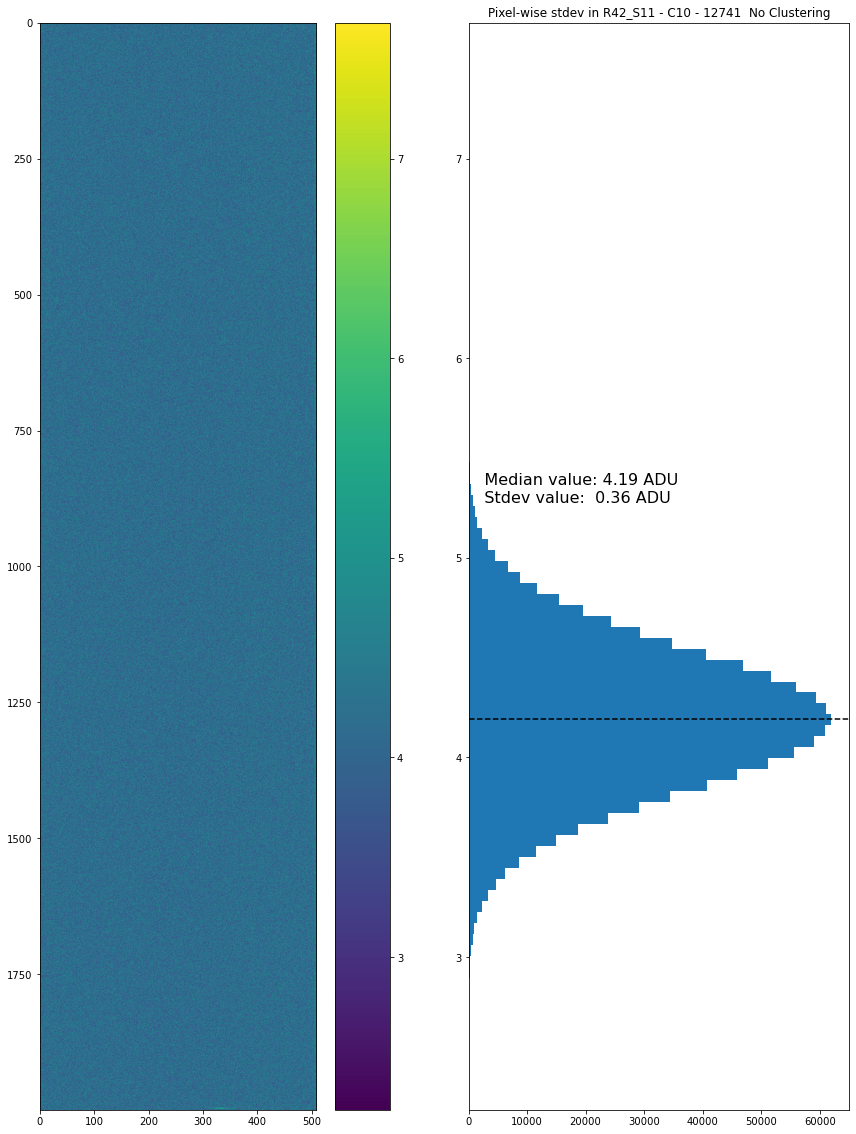

In [163]:
plot_im_and_hist(std_im, median=True, title=f'Pixel-wise stdev in {detname} - {amp.getName()} - {runnum}  No Clustering', save_file=f'plots/Pixel-wise stdev in {detname} - {amp.getName()} - {runnum} - No Clustering.png' ,show=True)

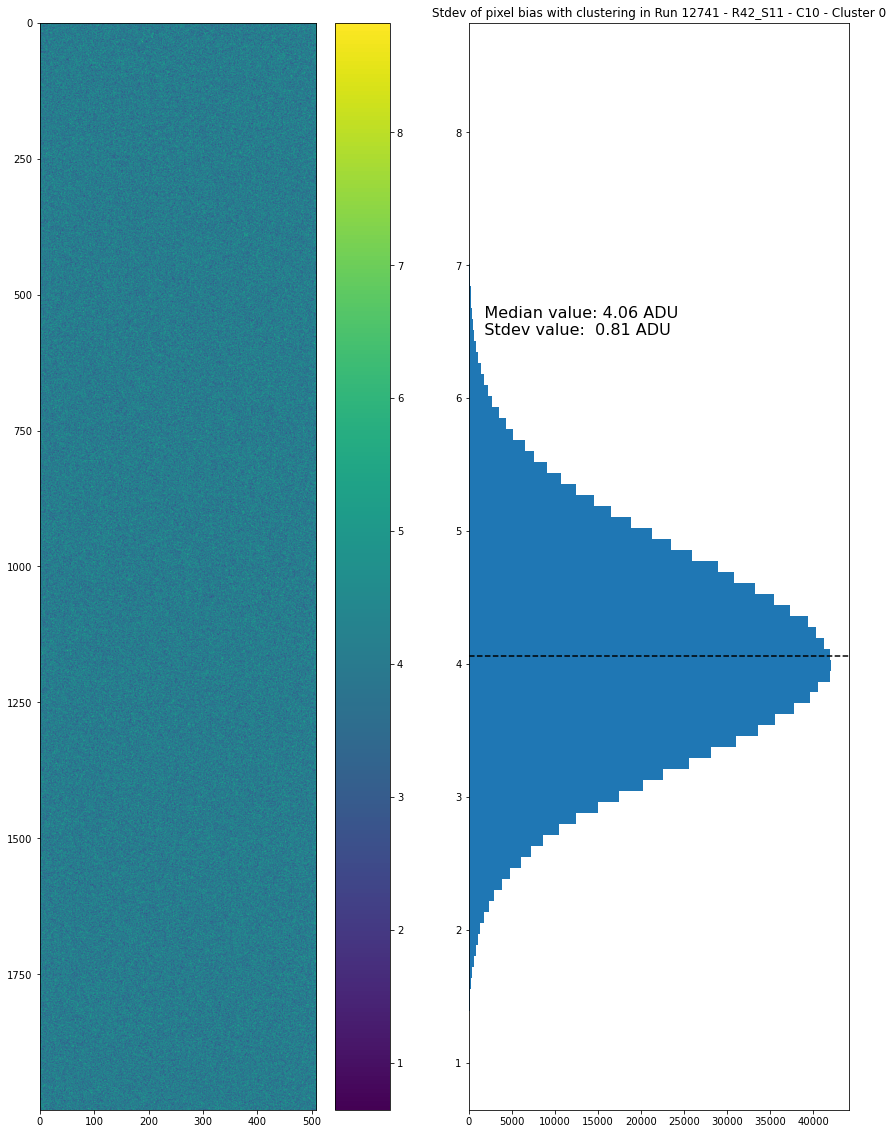

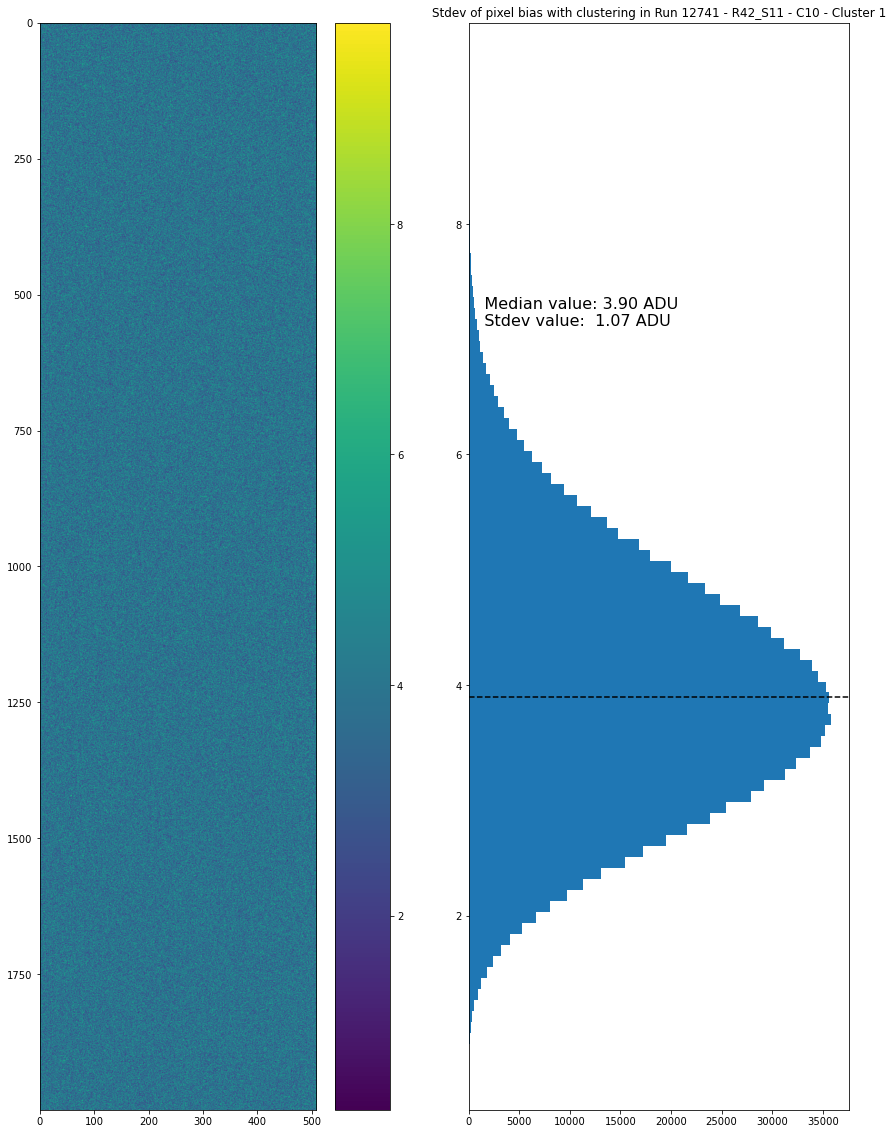

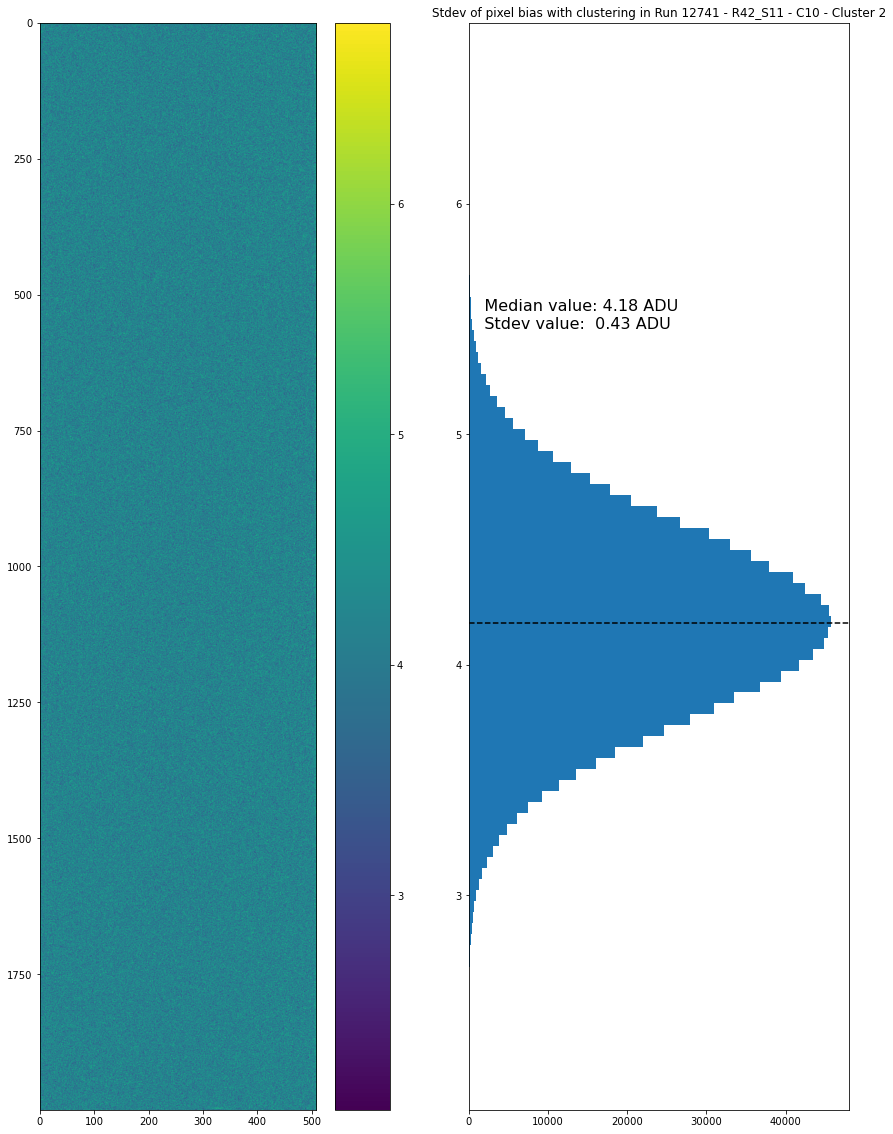

In [168]:
for i,cluster in enumerate(std_ims_dic[run]):
    plot_im_and_hist(cluster,  save_file=f'plots/std_clustering_{run}_{detname}_{amp.getName()}-cluster{i}', title=f'Stdev of pixel bias with clustering in Run {run} - {detname} - {amp.getName()} - Cluster {i}', median=True, show=True)

In [171]:
std_ims_dic

{'12741': [array([[2.83021778, 3.77206213, 3.54123531, ..., 5.06084074, 3.30397451,
          4.39721681],
         [3.03080691, 3.48103521, 4.59436789, ..., 3.58953354, 3.15341161,
          4.10362886],
         [5.44038069, 4.07707435, 4.54142761, ..., 4.79005301, 4.6363054 ,
          4.55517247],
         ...,
         [4.49058784, 3.17861191, 3.32820288, ..., 3.55642391, 5.68066387,
          4.09129299],
         [4.26108796, 2.38932767, 4.05162862, ..., 3.12727694, 5.20732567,
          3.61740875],
         [2.52861782, 2.89717732, 3.73126752, ..., 3.90198244, 4.10936833,
          4.4435489 ]]),
  array([[3.72404236, 1.63222785, 4.6004355 , ..., 4.46494364, 5.55345777,
          4.03491449],
         [4.19389885, 5.25539711, 4.09075062, ..., 6.30402149, 5.0454173 ,
          4.14274338],
         [3.31792323, 4.03640152, 5.36392294, ..., 3.98409097, 4.73805273,
          4.31983587],
         ...,
         [3.02741279, 4.18852746, 4.59328934, ..., 3.89327063, 3.23155676,
    

In [169]:
lens =  np.asarray([len(cluster) for cluster in dIds_clustered])
comp_stdev = np.sqrt(np.tensordot(lens, np.asarray(std_ims_dic[run])**2, axes=1)/np.sum(lens))

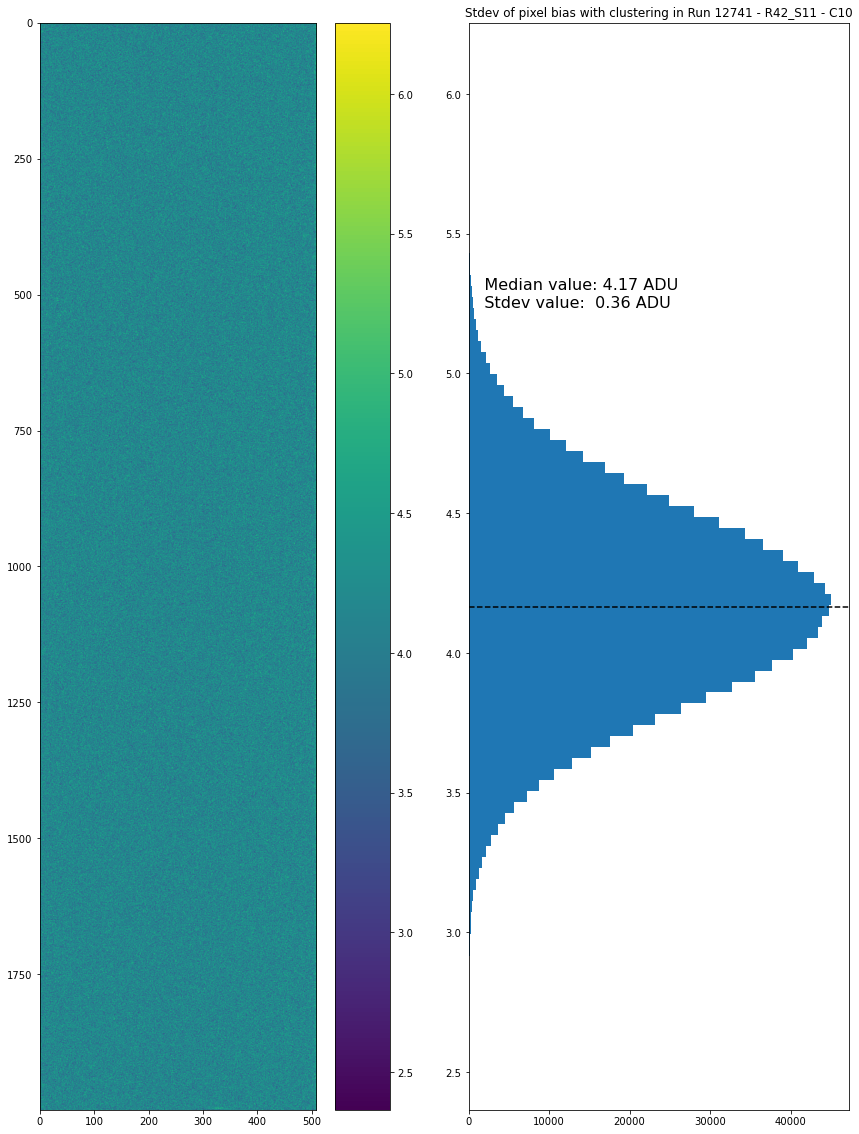

In [170]:
plot_im_and_hist(comp_stdev, save_file=f'plots/std_clustering_{run}_{detname}_{amp.getName()}', title=f'Stdev of pixel bias with clustering in Run {run} - {detname} - {amp.getName()}', median=True)

In [95]:
clim

(2.363555447956073, 6.366961176198565)

In [79]:
lens-1

array([14,  7, 57])

In [77]:
print(clims)

None


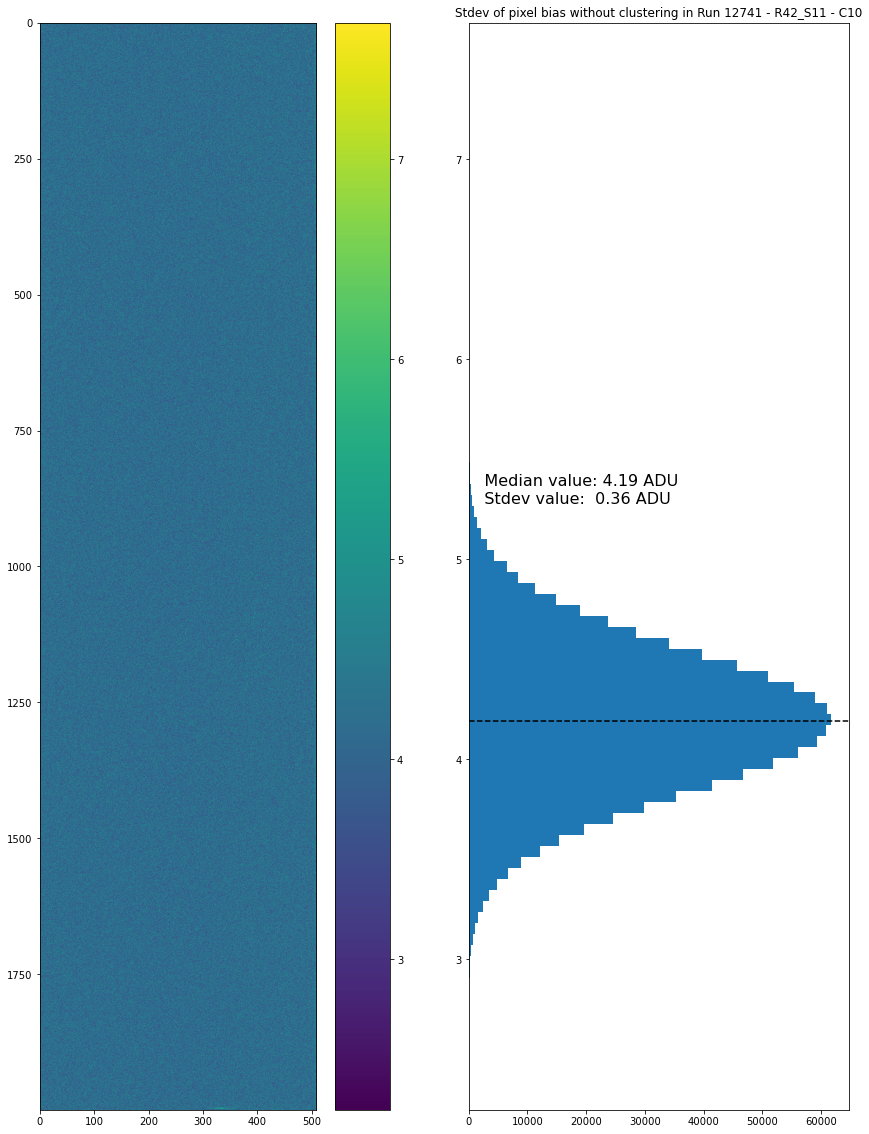

In [153]:
unclustered_stdev = np.asarray(unclustered_stds[run])
plot_im_and_hist(unclustered_stdev,  save_file=f'plots/std_noclustering_{run}_{detname}_{amp.getName()}', title=f'Stdev of pixel bias without clustering in Run {run} - {detname} - {amp.getName()}', median=True)

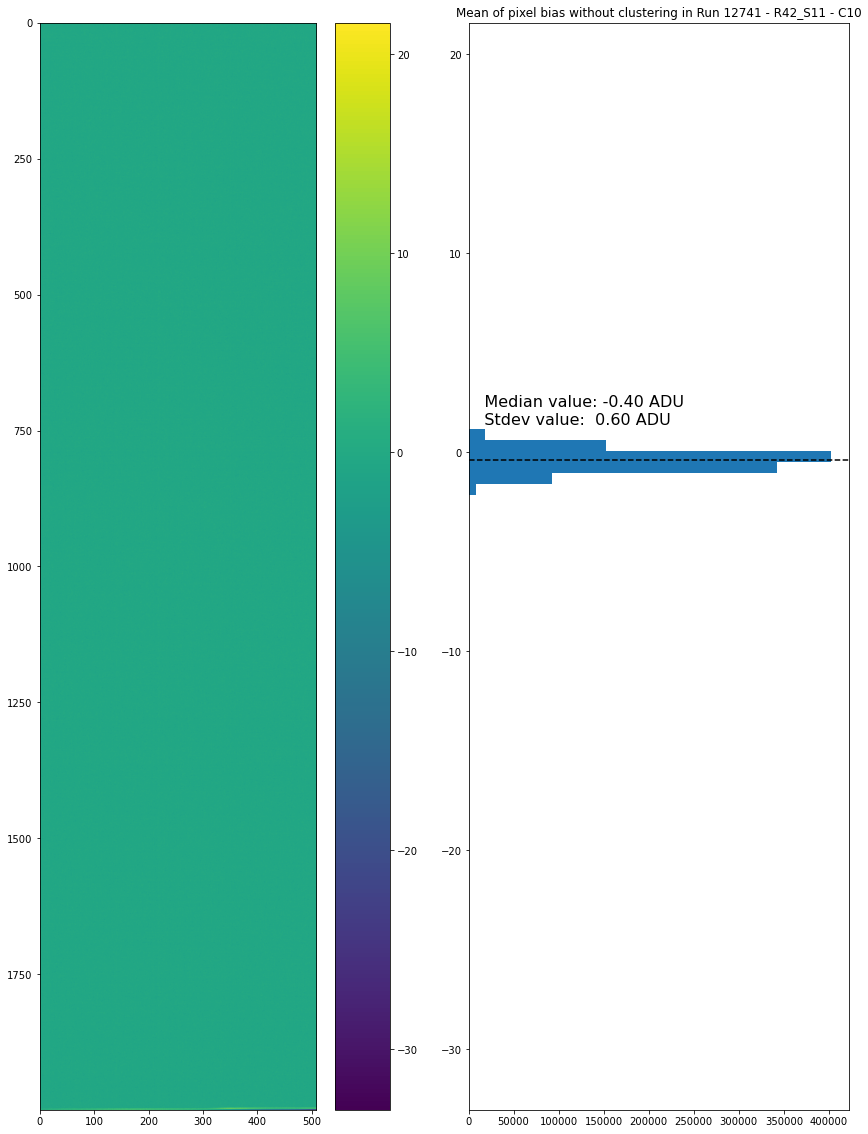

In [172]:
unclustered_mean = np.asarray(unclustered_means[run])
plot_im_and_hist(unclustered_mean,  save_file=f'plots/mean_noclustering_{run}_{detname}_{amp.getName()}', title=f'Mean of pixel bias without clustering in Run {run} - {detname} - {amp.getName()}', median=True)

In [173]:
np.sum(lens)

81

In [176]:
dir(det)

['Builder',
 'InCameraBuilder',
 'PartialRebuilder',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'fromConfig',
 'getAmplifiers',
 'getBBox',
 'getCenter',
 'getCorners',
 'getCrosstalk',
 'getId',
 'getName',
 'getNativeCoordSys',
 'getOrientation',
 'getPhysicalType',
 'getPixelSize',
 'getSerial',
 'getTransform',
 'getTransformMap',
 'getType',
 'hasCrosstalk',
 'hasTransform',
 'isPersistable',
 'makeCameraSys',
 'readFits',
 'rebuild',
 'transform',
 'writeFits']

In [44]:
corrector = dark_bias.PCA_Corrector(exps, amp)

In [45]:
corrected_arr = dark_bias.do_PCA_correction(exps, corrector)

In [46]:
corrected_arr.shape

(15, 2000, 509)

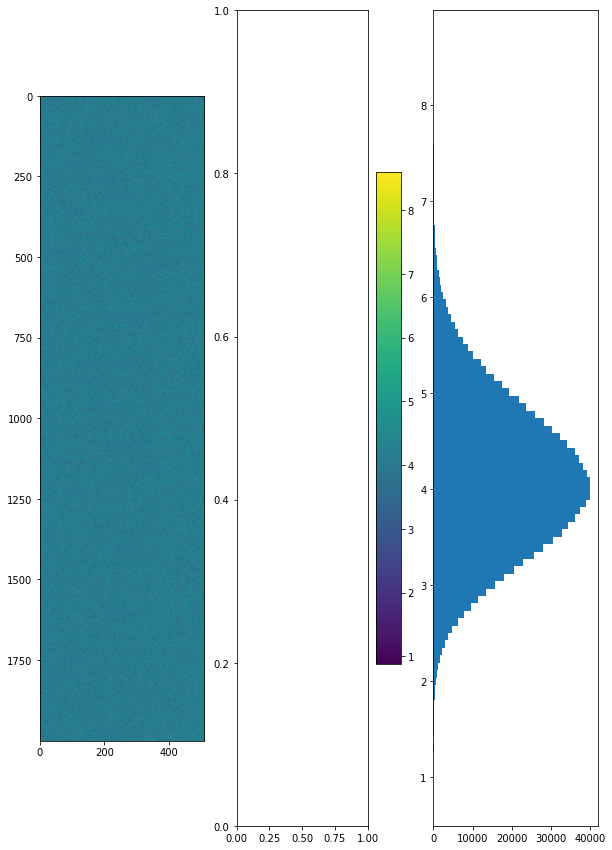

In [63]:
fig, axes = plt.subplots(1,2,figsize=(10,15))
implot = axes[0].imshow(np.std(corrected_arr, axis=0))
plt.colorbar(implot ax=axes[0])
axes[1].hist(np.std(corrected_arr, axis=0).flat,bins=100, orientation="horizontal")

plt.show()

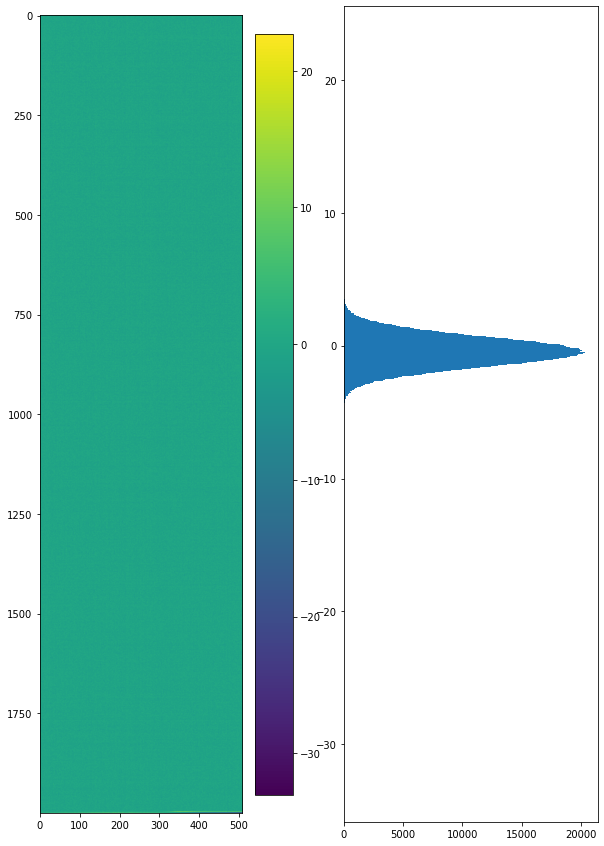

In [48]:
fig, axes = plt.subplots(1,2,figsize=(10,15))
implot = axes[0].imshow(np.mean(corrected_arr, axis=0))
plt.colorbar(implot, ax=axes[0])
axes[1].hist(np.mean(corrected_arr, axis=0).flat,bins=1000,orientation="horizontal")

plt.show()

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.svm as svm

#lin_clf = svm.LinearSVR()
#lin_clf.fit(X, Y)
#LinearSVC()
#dec = lin_clf.decision_function([[1]])
#dec.shape[1]

clf = make_pipeline(StandardScaler(), svm.LinearSVC())
clf.fit(np.c_[X,Y])
clf.score(np.c_[X,Y])

ValueError: too many values to unpack (expected 2)

In [92]:
len(aspic_arr_1)

544

In [49]:
dId = registry.expandDataId(dIds[0])
print(dId.records['exposure'])

IndexError: list index out of range

In [ ]:
dId

In [24]:
exposure_list = list(registry.queryDimensionRecords("exposure"))

In [29]:
exposure_list[0].science_program

'6475D'

In [60]:
runs

{'11973',
 '11974',
 '12470',
 '12471',
 '12472',
 '12473',
 '12474',
 '12475',
 '12476',
 '12477',
 '12478',
 '12479',
 '12481',
 '12482',
 '12483',
 '12484',
 '12485',
 '12486',
 '12487',
 '12488',
 '12489',
 '12490',
 '12491',
 '12492',
 '12493',
 '12504',
 '12505',
 '12506',
 '12507',
 '12508',
 '12509',
 '12510',
 '12511',
 '12512',
 '12513',
 '12522',
 '12549',
 '12550',
 '12584',
 '12585',
 '12586',
 '12587',
 '12588',
 '12589',
 '12590',
 '12591',
 '12592',
 '12593',
 '12594',
 '12595',
 '12596',
 '12597',
 '12598',
 '12599',
 '12605',
 '12606',
 '12619',
 '12622',
 '12628',
 '12629',
 '12631',
 '12632',
 '12635',
 '12636',
 '12638',
 '12639',
 '12645',
 '12646',
 '12647',
 '12671',
 '12672',
 '12673',
 '12675',
 '12677',
 '12678',
 '12679',
 '12682',
 '12683',
 '12684',
 '12686',
 '12687',
 '12688',
 '12691',
 '12692',
 '12693',
 '12694',
 '12696',
 '12697',
 '12698',
 '12699',
 '12700',
 '12701',
 '12702',
 '12703',
 '12704',
 '12705',
 '12706',
 '12707',
 '12708',
 '12717',


In [32]:
'7004D' in runs

False

In [41]:
days = set()
for expid in exposure_list:
    #expid = registry.expandDataId(expid)
    days.add(expid.day_obs)

In [39]:
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

In [41]:
X

array([[  6.37734541, -10.61510727],
       [  6.50072722,  -3.82403586],
       [  4.29225906,  -8.99220442],
       [  7.39169472,  -3.1266933 ],
       [  7.64306311, -10.02356892],
       [  8.68185687,  -4.53683537],
       [  5.37042238,  -2.44715237],
       [  9.24223825,  -3.88003098],
       [  5.73005848,  -4.19481136],
       [  7.9683312 ,  -3.23125265],
       [  7.37578372,  -8.7241701 ],
       [  6.95292352,  -8.22624269],
       [  8.21201164,  -1.54781358],
       [  6.85086785,  -9.92422452],
       [  5.64443032,  -8.21045789],
       [ 10.48848359,  -2.75858164],
       [  7.27059007,  -4.84225716],
       [  6.29784608, -10.53468031],
       [  9.42169269,  -2.6476988 ],
       [  8.98426675,  -4.87449712],
       [  6.6008728 ,  -8.07144707],
       [  5.95313618,  -6.82945967],
       [  6.87151089, -10.18071547],
       [  6.26221548,  -8.43925752],
       [  7.97164446,  -3.38236058],
       [  7.67619643,  -2.82620437],
       [  7.92736799,  -9.7615272 ],
 

In [90]:
registry.dimensions(datalist[10000].dataId)

TypeError: 'DimensionUniverse' object is not callable

In [40]:
exposure_list[0].day_obs

20190319

In [ ]:
for item in c.dataId.values():
    print(item)

In [55]:
dtype = 'raw'#DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
datasets = subregistry.queryDatasets(datasetType=dtype,collections=collections)
#for dataset in datasets:
#    print(dataset)

In [56]:
datalist = list(datasets)

In [86]:
datalist[0].expanded(datalist[0].dataId)

DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {band: unknown, instrument: LSSTCam, detector: 116, physical_filter: unknown, exposure: 3020110700207}, id=1, run='LSSTCam/raw/all')

In [57]:

exp = subbutler.get(datalist[0])
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,10))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(exp.getImage())

raw@{band: unknown, instrument: LSSTCam, detector: 116, physical_filter: unknown, exposure: 3020110700207}, sc=Exposure] (id=1)


FileNotFoundError: Could not retrieve dataset raw@{band: unknown, instrument: LSSTCam, detector: 116, physical_filter: unknown, exposure: 3020110700207}, sc=Exposure] (id=1).

In [71]:
biases = subregistry.queryDatasets('raw', ['visit'], 
                                    dataId={'run':'7004D', 'imageType' : 'BIAS','raftName': raft,'detectorName': sensor})

TypeError: queryDatasets() takes 2 positional arguments but 3 positional arguments (and 1 keyword-only argument) were given

In [73]:
biases = subregistry.queryDimensions('raw', ['visit'], 
                                    dataId={'run':'7004D', 'imageType' : 'BIAS','raftName': raft,'detectorName': sensor})

AttributeError: 'Registry' object has no attribute 'queryDimensions'

In [ ]:
exp = subbutler.get(c.dataId)

In [62]:
dir(subbutler)

['GENERATION',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_config',
 '_findDatasetRef',
 '_standardizeArgs',
 '_unpickle',
 'collections',
 'datasetExists',
 'datastore',
 'export',
 'get',
 'getDeferred',
 'getDirect',
 'getDirectDeferred',
 'getURI',
 'getURIs',
 'import_',
 'ingest',
 'isWriteable',
 'makeRepo',
 'pruneCollection',
 'pruneDatasets',
 'put',
 'registry',
 'run',
 'storageClasses',
 'tags',
 'transaction',
 'validateConfiguration']